In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 422kB/s 
     |████████████████████████████████| 3.1MB 49.8MB/s 
     |████████████████████████████████| 501kB 58.1MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-09-09 17:08:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2019-09-09 17:08:45 (141 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



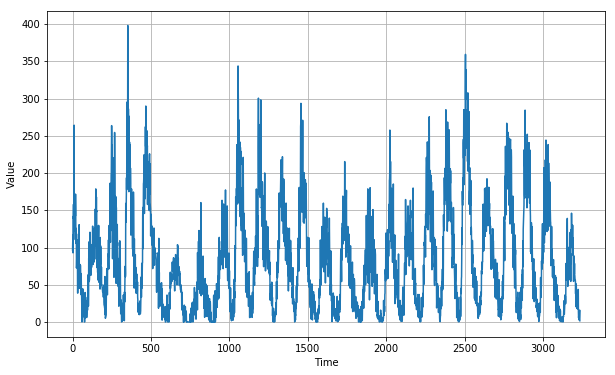

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

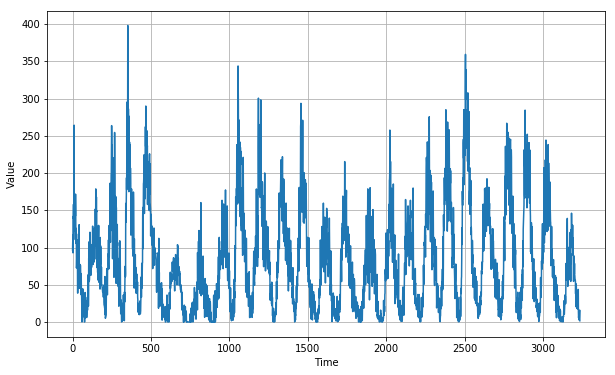

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 546ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 4s 357ms/step - loss: 78.5038 - mae: 78.5937
Epoch 3/100
12/12 [==============================] - 4s 355ms/step - loss: 75.8321 - mae: 75.9399
Epoch 4/100
12/12 [==============================] - 4s 359ms/step - loss: 72.6364 - mae: 72.7566
Epoch 5/100
12/12 [==============================] - 4s 362ms/step - loss: 69.1225 - mae: 69.2522
Epoch 6/100
12/12 [==============================] - 4s 363ms/step - loss: 65.4573 - mae: 65.5938
Epoch 7/100
12/12 [==============================] - 4s 363ms/step - loss: 61.8589 - mae: 61.9999
Epoch 8/100
12/12 [==============================] - 4s 360ms/step - loss: 58.4736 - mae: 58.6180
Epoch 9/100
12/12 [=

[1e-08, 0.0001, 0, 60]

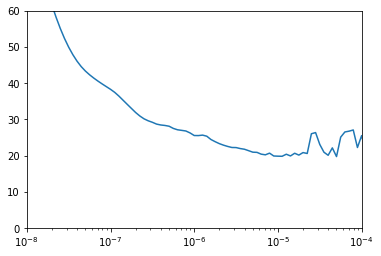

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 6s 196ms/step - loss: 37.8896 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 4s 126ms/step - loss: 24.3137 - mae: 24.8470
Epoch 3/500
30/30 [==============================] - 4s 125ms/step - loss: 21.0376 - mae: 21.5412
Epoch 4/500
30/30 [==============================] - 4s 125ms/step - loss: 20.2604 - mae: 20.7556
Epoch 5/500
30/30 [==============================] - 4s 123ms/step - loss: 19.6226 - mae: 20.1157
Epoch 6/500
30/30 [==============================] - 4s 123ms/step - loss: 19.2406 - mae: 19.7160
Epoch 7/500
30/30 [==============================] - 4s 123ms/step - loss: 18.8684 - mae: 19.3572
Epoch 8/500
30/30 [==============================] - 4s 122ms/step - loss: 18.6414 - mae: 19.1303
Epoch 9/500
30/30 [==============================] - 4s 121ms/step - loss: 18.3319 - mae: 18.8184
Epoch 10/500
30/30 [==============================] - 4s 122ms/step - loss: 18.0562 - mae: 18.5398
Epoch 11/500
30/30 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

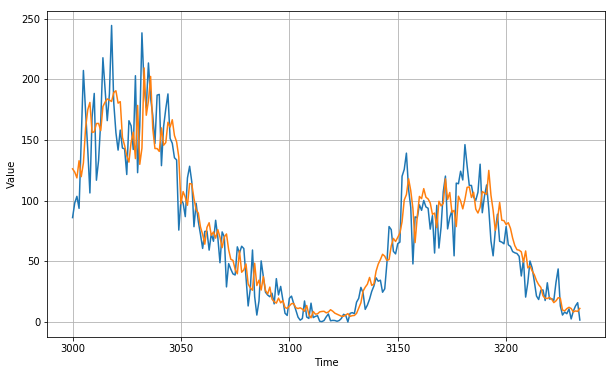

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.472123

<Figure size 432x288 with 0 Axes>

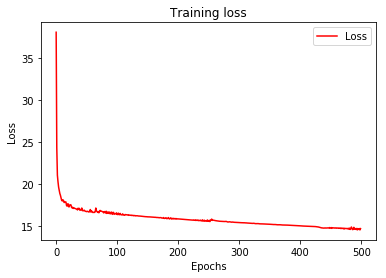

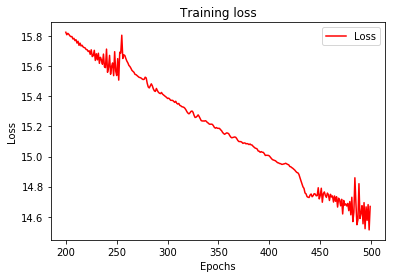

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[126.17376   123.49763   118.71698   132.8444    119.71278   131.0426
 159.7123    174.81494   180.8845    156.17044   156.6485    163.52107
 163.59355   157.6514    177.47095   181.14268   183.77678   182.8567
 181.68445   189.02428   190.51366   180.30048   181.54225   152.0596
 145.45972   136.8493    131.70099   147.94078   156.38983   134.60303
 178.43864   129.88184   143.20374   209.28867   170.33574   182.15956
 202.31421   159.35117   142.91582   142.88327   140.5145    159.9052
 145.63895   147.79672   164.54137   160.60583   166.6184    153.6318
 148.37546   135.9055     97.30059   107.44273   102.77123    96.144775
 114.076706  113.66007   101.71246    92.40133    89.772446   78.314896
  72.03176    64.093575   77.93597    81.77874    71.38627    74.16182
  69.083855   76.06215    69.93829    61.20775    70.01817    72.514496
  59.53175    51.626617   50.728573   43.282234   39.69892    58.560474
  40.985165   42.920464   47.79779    31.264198   28.0061     26.128742
  48.4